## Poverty

In [53]:
import numpy as np 
import pandas as pd 
import folium
from folium.plugins import HeatMap
import seaborn as sns
from functools import reduce
import geopandas as gpd

In [54]:
kiva_mpi_region_locations = pd.read_csv('../input/data-science-for-good-kiva-crowdfunding/kiva_mpi_region_locations.csv')

In [55]:
def create_heatmap_coords(row, metric, coord1, coord2):
    return [row[coord1], row[coord2], row[metric]]

def create_coords(row, coord1, coord2):
    return [row[coord1], row[coord2]]

def create_heatmap_coords_column(df, col_title='heatmap_coords', metric='MPI', coord1='longitude', coord2='latitude'):
    df[col_title] = df.apply(lambda x: create_heatmap_coords(x, metric, coord1, coord2), axis=1)
    
def create_coords_column(df, coord1='longitude', coord2='latitude'):
    df['coords'] = df.apply(lambda x: create_coords(x, coord1, coord2), axis=1)
    
def get_coords_of_n_smallest(df, name='Country', metric='MPI', n=10):
    return np.array(df.sort_values(by=[metric])[['coords', name, metric]][:n])
def get_coords_of_n_largest(df, name='Country', metric='MPI', n=10):
    return np.array(df.sort_values(by=[metric])[['coords', name, metric]][-n:])

kiva_mpi_region_locations = kiva_mpi_region_locations.dropna()
kiva_mpi_region_locations = kiva_mpi_region_locations[(kiva_mpi_region_locations['LocationName'] != 'Lac, Chad') &
                                                      (kiva_mpi_region_locations['LocationName'] != 'Logone Occidental, Chad') &
                                                      (kiva_mpi_region_locations['LocationName'] != 'Logone Oriental, Chad') &
                                                      (kiva_mpi_region_locations['LocationName'] != 'Kanem, Chad') &
                                                      (kiva_mpi_region_locations['LocationName'] != 'Hama, Syrian Arab Republic') &
                                                      (kiva_mpi_region_locations['LocationName'] != 'Tortous, Syrian Arab Republic') &
                                                      (kiva_mpi_region_locations['LocationName'] != 'Gharbia, Egypt') &
                                                      (kiva_mpi_region_locations['LocationName'] != 'Matroh, Egypt') &
                                                      (kiva_mpi_region_locations['LocationName'] != 'Port Said, Egypt') &
                                                      (kiva_mpi_region_locations['LocationName'] != 'Bogota, Colombia') & 
                                                      (kiva_mpi_region_locations['LocationName'] != 'Orinoquia Y Amazonia, Colombia') & 
                                                      (kiva_mpi_region_locations['LocationName'] != 'Central-Eastern, Uzbekistan') &
                                                      (kiva_mpi_region_locations['LocationName'] != 'Southern, Uzbekistan') &
                                                      (kiva_mpi_region_locations['LocationName'] != 'Eastern, Uzbekistan') &
                                                      (kiva_mpi_region_locations['LocationName'] != 'St. Ann, Jamaica') 
                                                     ]
create_heatmap_coords_column(kiva_mpi_region_locations, coord1='lat', coord2='lon')
create_coords_column(kiva_mpi_region_locations, coord1='lat', coord2='lon')
lowest_MPI = get_coords_of_n_smallest(kiva_mpi_region_locations, name='LocationName')
highest_MPI = get_coords_of_n_largest(kiva_mpi_region_locations, name='LocationName')


In [56]:
def add_markers_to_map(head_map, coords, metric='MPI', num_markers=10, color='green', icon='info-sign', prefix='glyphicon'):
    for i in range(num_markers):
        folium.Marker(
            location=coords[i][0],
            icon=folium.Icon(color=color, icon=icon, prefix=prefix),
            popup='{}, {} {}'.format(coords[i][1], metric, coords[i][2])
        ).add_to(head_map)

common_map = folium.Map(location=[10, 0], zoom_start=3)
hm = HeatMap(kiva_mpi_region_locations['heatmap_coords'], radius=15, blur=5)
hm.add_to(common_map)
add_markers_to_map(common_map, lowest_MPI)
add_markers_to_map(common_map, highest_MPI, color='red')
common_map

In [57]:
mpi_national = pd.read_csv('../input/mpi/MPI_national.csv')
lat_long_info = pd.read_csv('../input/world-countries-and-continents-details/Countries Longitude and Latitude.csv')
countries = gpd.read_file('../input/countries-shape-files/ne_10m_admin_0_countries.shp')

In [58]:
country_mappings_a = {
    'United Kingdom': 'UK',
    'United States': 'US',
    'Venezuela, RB': 'Venezuela',
    'Yemen, Rep.': 'Yemen',
    'West Bank and Gaza': 'Palestine',
    'Korea, Rep.': 'South Korea',
    'Korea, Dem. People’s Rep.': 'North Korea',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Lao PDR': 'Laos',
    'St. Martin (French part)': 'St. Martin',
    'Syrian Arab Republic': 'Syria',
    'Micronesia, Fed. Sts.': 'Micronesia',
    'Russian Federation': 'Russia',
    'Macedonia, FYR': 'Macedonia',
    'Macao SAR, China': 'Macau',
    'Iran, Islamic Rep.': 'Iran',
    'Hong Kong SAR, China': 'Hong Kong',
    'Egypt, Arab Rep.': 'Egypt',
    'Virgin Islands (U.S.)': 'U.S. Virgin Islands',
    'Congo, Dem. Rep.': 'Congo - Kinshasa',
    'Congo, Rep.': 'Congo - Brazzaville',
    'Brunei Darussalam': 'Brunei',
    'Bahamas, The': 'Bahamas',
    'Gambia, The': 'Gambia'
}

country_mappings_b = {
    'Macedonia, The former Yugoslav Republic of': 'Macedonia',
    'Moldova, Republic of': 'Moldova',
    'Syrian Arab Republic': 'Syria',
    'Viet Nam': 'Vietnam',
    "Lao People's Democratic Republic": 'Laos',
    'Central African Republic': 'Central African Rep.',
    'Congo, Democratic Republic of the': 'Dem. Rep. Congo',
    'Congo, Republic of': 'Congo',
    "Cote d'Ivoire": "CÃ´te d'Ivoire",
    'Tanzania, United Republic of': 'Tanzania'
}

In [59]:
def rename_df_columns(df, current_names, new_names):
    assert len(current_names) == len(new_names)
    columns = {key: new_names[i] for i, key in enumerate(current_names)}
    return df.rename(index=str, columns=columns)

def merge_dfs_on_column(dfs, column_name='Country'):
    return reduce(lambda left,right: pd.merge(left,right,on=column_name), dfs)

# helper function to shift the lat and long coords of markers to prevent positioning on top of each other
def shift_coords(df, amount_coord1, amount_coord2):
    df['latitude'] = df['latitude'] + amount_coord1
    df['longitude'] = df['longitude'] + amount_coord2
    return df

def update_country_names(df, mappings):
    # Update the country names before merge to avoid losing data
    for key in mappings.keys():
        df.loc[df.Country == key, 'Country'] = mappings[key]
    return df
    
def update_country_profile_with_coords(profile_df, mappings, coords_df, shift=True, amount_coord1=0, amount_coord2=0.5):
    profile_df = update_country_names(profile_df, mappings)  
    coords_df = shift_coords(coords_df, amount_coord1, amount_coord2) if shift else coords_df
    profile_updated = merge_dfs_on_column([coords_df, profile_df])
    return profile_updated

mpi_national['MPI Diff'] = mpi_national['MPI Rural'] - mpi_national['MPI Urban']
lat_long_info = rename_df_columns(lat_long_info, ['name'], ['Country'])
mpi_national_updated_a = update_country_profile_with_coords(mpi_national, country_mappings_a, lat_long_info, shift=False)
create_coords_column(mpi_national_updated_a)

countries = rename_df_columns(countries, ['NAME'], ['Country'])
countries.geometry = countries.geometry.simplify(0.3)
mpi_national_updated_b = update_country_profile_with_coords(mpi_national, country_mappings_b, countries, shift=False)

lowest_MPI_urban = get_coords_of_n_smallest(mpi_national_updated_a, metric='MPI Urban')
highest_MPI_urban = get_coords_of_n_largest(mpi_national_updated_a, metric='MPI Urban')
lowest_MPI_rural = get_coords_of_n_smallest(mpi_national_updated_a, metric='MPI Rural')
highest_MPI_rural = get_coords_of_n_largest(mpi_national_updated_a, metric='MPI Rural')
lowest_MPI_diff = get_coords_of_n_smallest(mpi_national_updated_a, metric='MPI Diff')
highest_MPI_diff = get_coords_of_n_largest(mpi_national_updated_a, metric='MPI Diff')

In [60]:
import folium

# Convert geometry to GeoJSON format
base_layer = countries.geometry.to_json()
mpi_layer = mpi_national_updated_b[['Country', 'geometry']].to_json()

# Style function for the base layer
style_function = lambda x: {'fillColor': '#ffffff', 'color': '#000000', 'weight': 1}

# Create the base map
urban_map = folium.Map(location=[10, 0], zoom_start=2)

# Add the base layer to the map
folium.GeoJson(
    base_layer,
    name='base',
    style_function=style_function
).add_to(urban_map)

# Create the choropleth layer
choropleth_layer = folium.Choropleth(
    geo_data=mpi_layer,
    name='mpi urban choropleth',
    key_on='feature.properties.Country',
    fill_color='YlOrRd',
    data=mpi_national_updated_b,
    columns=['Country', 'MPI Urban'],
    legend_name='MPI Urban'
)

# Add the choropleth layer to the map
choropleth_layer.add_to(urban_map)

# Add layer control
folium.LayerControl().add_to(urban_map)

# Assuming add_markers_to_map is a function to add markers
add_markers_to_map(urban_map, lowest_MPI_urban, metric='MPI Urban')
add_markers_to_map(urban_map, highest_MPI_urban, metric='MPI Urban', color='red')

# Display the map
urban_map


In [61]:
import folium

# Assuming you have defined style_function, base_layer, mpi_layer, and mpi_national_updated_b

# Create the rural map
rural_map = folium.Map(location=[10, 0], zoom_start=2)

# Add the base layer to the rural map
folium.GeoJson(
    base_layer,
    name='base',
    style_function=style_function
).add_to(rural_map)

# Create the choropleth layer for the rural map
choropleth_layer_rural = folium.Choropleth(
    geo_data=mpi_layer,
    name='mpi rural choropleth',
    key_on='feature.properties.Country',
    fill_color='YlOrRd',
    data=mpi_national_updated_b,
    columns=['Country', 'MPI Rural'],
    legend_name='MPI Rural'
)

# Add the choropleth layer to the rural map
choropleth_layer_rural.add_to(rural_map)

# Add layer control
folium.LayerControl().add_to(rural_map)

# Assuming add_markers_to_map is a function to add markers
add_markers_to_map(rural_map, lowest_MPI_rural, metric='MPI Rural')
add_markers_to_map(rural_map, highest_MPI_rural, metric='MPI Rural', color='red')

# Display the rural map
rural_map


In [62]:
import folium

diff_map = folium.Map(location=[10, 0], zoom_start=2)

folium.GeoJson(
    base_layer,
    name='base',
    style_function=style_function
).add_to(diff_map)

choropleth_layer_diff = folium.Choropleth(
    geo_data=mpi_layer,
    name='mpi diff choropleth',
    key_on='feature.properties.Country',
    fill_color='YlOrRd',
    data=mpi_national_updated_b,
    columns=['Country', 'MPI Diff'],
    legend_name='MPI Diff'
)

choropleth_layer_diff.add_to(diff_map)

folium.LayerControl().add_to(diff_map)

add_markers_to_map(diff_map, lowest_MPI_diff, metric='MPI Diff')
add_markers_to_map(diff_map, highest_MPI_diff, metric='MPI Diff', color='red')

diff_map


<Axes: >

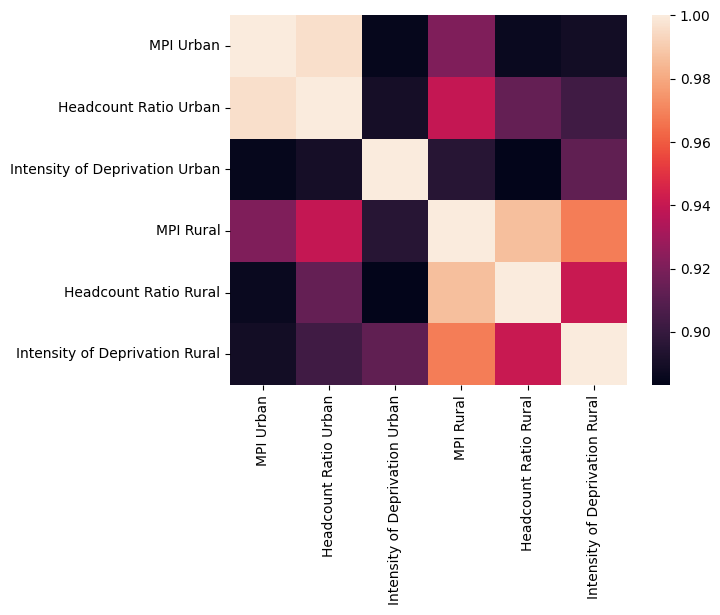

In [63]:
pov_metrics = mpi_national_updated_a[['MPI Urban', 'Headcount Ratio Urban', 'Intensity of Deprivation Urban', 'MPI Rural', 'Headcount Ratio Rural', 'Intensity of Deprivation Rural']]
corr = pov_metrics.corr()
sns.heatmap(corr)

Looking at the Pearson correlations between various indicators in the Multidimensional Poverty Measures dataset we can see that they are all very highly correlated. There's a correlation of nearly 1 between MPI Urban and Headcount Ration Urban as well as MPI Rural and Headcount Ratio Rural, i.e. the higher the MPIs the greater the number of people in urban and rural areas live under poverty line.

### Global Peace Index

In [64]:
gpi = pd.read_csv('../input/gpi2008-2016/gpi_2008-2016.csv')

In [65]:
country_mappings = {
    'United Kingdom': 'UK',
    'United States': 'US',
    'Ivory Coast': 'Côte d’Ivoire',
    'Democratic Republic of the Congo': 'Congo - Kinshasa',
    'Republic of the Congo': 'Congo - Brazzaville'
}
gpi = rename_df_columns(gpi, ['country'], ['Country'])
gpi = update_country_profile_with_coords(gpi, country_mappings, lat_long_info)
create_coords_column(gpi)
gpi['av_2012_2015'] = gpi[['score_2012', 'score_2013', 'score_2014', 'score_2015']].mean(axis=1)
lowest_score = get_coords_of_n_smallest(gpi, metric='av_2012_2015')
highest_score = get_coords_of_n_largest(gpi, metric='av_2012_2015')

In [66]:
add_markers_to_map(urban_map, lowest_score, metric='global peace index', color='lightgreen', icon='bomb', prefix='fa')
add_markers_to_map(urban_map, highest_score, metric='global peace index', color='purple', icon='bomb', prefix='fa')
urban_map 

### World Happiness Report

In [1]:
whr_2015 = pd.read_csv('../input/world-happiness/2015.csv')

NameError: name 'pd' is not defined

In [ ]:
country_mappings = {
    'United Kingdom': 'UK',
    'United States': 'US',
    'Ivory Coast': 'Côte d’Ivoire',
    'Congo (Kinshasa)': 'Congo - Kinshasa',
    'Congo (Brazzaville)': 'Congo - Brazzaville',
    'Palestinian Territories': 'Palestine'
}
whi = update_country_profile_with_coords(whr_2015, country_mappings, lat_long_info, amount_coord1=-0.5, amount_coord2=0)
create_coords_column(whi)
lowest_rank = get_coords_of_n_smallest(whi, metric='Happiness Rank')
highest_rank = get_coords_of_n_largest(whi, metric='Happiness Rank')

In [ ]:
add_markers_to_map(urban_map, lowest_rank, metric='Happiness Rank', color='darkgreen', icon='thumbs-up')
add_markers_to_map(urban_map, highest_rank, metric='Happiness Rank', color='darkpurple', icon='thumbs-down')
urban_map